In [12]:
!pip install fasttext-wheel

  Using cached pybind11-2.13.5-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.5-py3-none-any.whl (240 kB)


In [1]:
import pandas as pd
import numpy as np
import fasttext
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\User\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [29]:
df = pd.read_excel('Downloads/blame_dataset_v2.xlsx') 
df = df.rename(columns={'Blame/Praise/Other' : 'Label'})
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,Illustration: Chen Xian/Global TimesUkraine is...,Other
1,Article 1,NaN,Sentence 2,Several European diplomats confirmed Tuesday t...,Other
2,Article 1,NaN,Sentence 3,In the context of the ongoing Russia-Ukraine c...,Other
3,Article 1,NaN,Sentence 4,"Apparently, the EU has been completely hijacke...",Blame
4,Article 1,NaN,Sentence 5,"Facing a dilemma, it had no choice but to open...",Blame


In [30]:
df.shape

(436, 5)

In [31]:
missing_values = df.isnull().sum()
print(missing_values)

Article ID           0
Article's topic    426
Sentence ID          0
Sentence             0
Label              224
dtype: int64


In [32]:
#check unique classes
df['Label'].unique()

array(['Other ', 'Blame', 'Blame/Praise', 'Blame ', 'Praise ', nan,
       'Blame / Praise', 'Blame  ', 'Criticism '], dtype=object)

In [33]:
df = df.dropna(subset=['Label']) #or use df = df[df['Label'].notna()]
df['Label'] = df['Label'].str.strip()
df = df[df['Sentence'].apply(lambda x: len(x.split()) >= 3)]
df = df[~df['Label'].isin(['Blame/Praise', 'Blame / Praise', 'Criticism'])]

In [34]:
df.shape

(194, 5)

In [36]:
df.Label.value_counts()

Label
Blame     99
Other     75
Praise    20
Name: count, dtype: int64

## Preprocessing

In [37]:
#Library import for preprocessing
pd.set_option('display.max_colwidth', None)
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Case Folding

In [38]:
df['Sentence'] = df['Sentence'].str.lower()
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,illustration: chen xian/global timesukraine is set to become an official candidate for european union (eu) membership at the eu summit to be held on thursday and friday.,Other
1,Article 1,NaN,Sentence 2,several european diplomats confirmed tuesday that no countries raised objections at a meeting of the bloc's ambassadors on monday.,Other
2,Article 1,NaN,Sentence 3,"in the context of the ongoing russia-ukraine conflict, ukraine's eu candidacy appears to be a symbolic decision, through which european countries have reaffirmed their political support for ukraine and encouraged the eastern european country to ""hang in there"" in the war.",Other
3,Article 1,NaN,Sentence 4,"apparently, the eu has been completely hijacked by nato and the us vis-à-vis this war.",Blame
4,Article 1,NaN,Sentence 5,"facing a dilemma, it had no choice but to open its arms to ukraine's membership, because supporting ukraine - no matter what - has become new ""political correctness"" in the west.",Blame


### Cleansing

In [39]:
def cleansing(sentences):
    #remove specific links
    sentences = re.sub(r'\b(?:https?://|www\.)\S+\b', '', sentences)
    #remove email addresses
    sentences = re.sub(r'\b(?:opinion@globaltimes\.com\.cn|dinggang@globaltimes\.com\.cn)\b', '', sentences)
    #remove specific patterns (photo: ...)
    sentences = re.sub(r'\(photo: (?:[a-zA-Z0-9]+\.[a-zA-Z]+|\S+)\)', '', sentences)
    #remove patterns like note: ..., cartoon:...
    sentences = re.sub(r'\bphoto: \S+', '', sentences)
    sentences = re.sub(r'\billustration: \S+', '', sentences)
    sentences = re.sub(r'\bnote: \S+', '', sentences)
    sentences = re.sub(r'\bcartoon: \S+', '', sentences)
    #remove possessive 's
    sentences = re.sub(r'\b\'s\b', '', sentences)
    #remove \n characters
    sentences = sentences.replace('\n', ' ')
    #remove other punctuation except "-"
    clean_sentences = re.sub(r'(@[A-Za-z0-9]+)|#[A-Za-z0-9]+|[^A-Za-z\s\'-]', ' ', sentences)
    return clean_sentences

In [40]:
df['Sentence'] = df['Sentence'].apply(cleansing)
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,xian global timesukraine is set to become an official candidate for european union eu membership at the eu summit to be held on thursday and friday,Other
1,Article 1,NaN,Sentence 2,several european diplomats confirmed tuesday that no countries raised objections at a meeting of the bloc ambassadors on monday,Other
2,Article 1,NaN,Sentence 3,in the context of the ongoing russia-ukraine conflict ukraine eu candidacy appears to be a symbolic decision through which european countries have reaffirmed their political support for ukraine and encouraged the eastern european country to hang in there in the war,Other
3,Article 1,NaN,Sentence 4,apparently the eu has been completely hijacked by nato and the us vis- -vis this war,Blame
4,Article 1,NaN,Sentence 5,facing a dilemma it had no choice but to open its arms to ukraine membership because supporting ukraine - no matter what - has become new political correctness in the west,Blame


### Tokenization

In [41]:
def tokenize(sentences):
    return word_tokenize(sentences)

In [42]:
df['Sentence'] = df['Sentence'].apply(tokenize)
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,"[xian, global, timesukraine, is, set, to, become, an, official, candidate, for, european, union, eu, membership, at, the, eu, summit, to, be, held, on, thursday, and, friday]",Other
1,Article 1,NaN,Sentence 2,"[several, european, diplomats, confirmed, tuesday, that, no, countries, raised, objections, at, a, meeting, of, the, bloc, ambassadors, on, monday]",Other
2,Article 1,NaN,Sentence 3,"[in, the, context, of, the, ongoing, russia-ukraine, conflict, ukraine, eu, candidacy, appears, to, be, a, symbolic, decision, through, which, european, countries, have, reaffirmed, their, political, support, for, ukraine, and, encouraged, the, eastern, european, country, to, hang, in, there, in, the, war]",Other
3,Article 1,NaN,Sentence 4,"[apparently, the, eu, has, been, completely, hijacked, by, nato, and, the, us, vis-, -vis, this, war]",Blame
4,Article 1,NaN,Sentence 5,"[facing, a, dilemma, it, had, no, choice, but, to, open, its, arms, to, ukraine, membership, because, supporting, ukraine, -, no, matter, what, -, has, become, new, political, correctness, in, the, west]",Blame


### Stopword Removal

In [43]:
def stop_removal(sentences):
    words = stopwords.words('english')
    words = set(words)
    words.add("'s")
    return [word for word in sentences if word not in words]

In [44]:
df['Sentence'] = df['Sentence'].apply(stop_removal)
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,"[xian, global, timesukraine, set, become, official, candidate, european, union, eu, membership, eu, summit, held, thursday, friday]",Other
1,Article 1,NaN,Sentence 2,"[several, european, diplomats, confirmed, tuesday, countries, raised, objections, meeting, bloc, ambassadors, monday]",Other
2,Article 1,NaN,Sentence 3,"[context, ongoing, russia-ukraine, conflict, ukraine, eu, candidacy, appears, symbolic, decision, european, countries, reaffirmed, political, support, ukraine, encouraged, eastern, european, country, hang, war]",Other
3,Article 1,NaN,Sentence 4,"[apparently, eu, completely, hijacked, nato, us, vis-, -vis, war]",Blame
4,Article 1,NaN,Sentence 5,"[facing, dilemma, choice, open, arms, ukraine, membership, supporting, ukraine, -, matter, -, become, new, political, correctness, west]",Blame


### Lemmatization with POS Tagging

In [45]:
def lemmatize_pos(words, pos):
  lemmatizer = WordNetLemmatizer()

  pos_mapping = {
      'N': 'n',
      'V': 'v',
      'R': 'r',
      'J': 'a'
  }

  wordnet_pos = pos_mapping.get(pos[0], 'n')
  if wordnet_pos == 'n':
    return lemmatizer.lemmatize(words, pos='v')
  return lemmatizer.lemmatize(words, pos=wordnet_pos)

In [46]:
#df['Sentence']  = df['Sentence'].apply(lambda x: [lemmatize_pos(words, pos) for words, pos in pos_tag(x)])
df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join([lemmatize_pos(words, pos) for words, pos in pos_tag(x)]))
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,xian global timesukraine set become official candidate european union eu membership eu summit hold thursday friday,Other
1,Article 1,NaN,Sentence 2,several european diplomats confirm tuesday countries raise objections meet bloc ambassadors monday,Other
2,Article 1,NaN,Sentence 3,context ongoing russia-ukraine conflict ukraine eu candidacy appear symbolic decision european countries reaffirm political support ukraine encourage eastern european country hang war,Other
3,Article 1,NaN,Sentence 4,apparently eu completely hijack nato us vis- -vis war,Blame
4,Article 1,NaN,Sentence 5,face dilemma choice open arm ukraine membership support ukraine - matter - become new political correctness west,Blame


## FastText

In [47]:
df['Label'] = "__label__" + df['Label'].astype(str)
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,xian global timesukraine set become official candidate european union eu membership eu summit hold thursday friday,__label__Other
1,Article 1,NaN,Sentence 2,several european diplomats confirm tuesday countries raise objections meet bloc ambassadors monday,__label__Other
2,Article 1,NaN,Sentence 3,context ongoing russia-ukraine conflict ukraine eu candidacy appear symbolic decision european countries reaffirm political support ukraine encourage eastern european country hang war,__label__Other
3,Article 1,NaN,Sentence 4,apparently eu completely hijack nato us vis- -vis war,__label__Blame
4,Article 1,NaN,Sentence 5,face dilemma choice open arm ukraine membership support ukraine - matter - become new political correctness west,__label__Blame


In [48]:
df['Label_Sentence'] = df['Label'] + " " + df['Sentence']
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label,Label_Sentence
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,xian global timesukraine set become official candidate european union eu membership eu summit hold thursday friday,__label__Other,__label__Other xian global timesukraine set become official candidate european union eu membership eu summit hold thursday friday
1,Article 1,NaN,Sentence 2,several european diplomats confirm tuesday countries raise objections meet bloc ambassadors monday,__label__Other,__label__Other several european diplomats confirm tuesday countries raise objections meet bloc ambassadors monday
2,Article 1,NaN,Sentence 3,context ongoing russia-ukraine conflict ukraine eu candidacy appear symbolic decision european countries reaffirm political support ukraine encourage eastern european country hang war,__label__Other,__label__Other context ongoing russia-ukraine conflict ukraine eu candidacy appear symbolic decision european countries reaffirm political support ukraine encourage eastern european country hang war
3,Article 1,NaN,Sentence 4,apparently eu completely hijack nato us vis- -vis war,__label__Blame,__label__Blame apparently eu completely hijack nato us vis- -vis war
4,Article 1,NaN,Sentence 5,face dilemma choice open arm ukraine membership support ukraine - matter - become new political correctness west,__label__Blame,__label__Blame face dilemma choice open arm ukraine membership support ukraine - matter - become new political correctness west


In [49]:
train, test = train_test_split(df, test_size=0.2, stratify=df['Label'])

In [50]:
train.shape, test.shape

((155, 6), (39, 6))

In [51]:
test.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label,Label_Sentence
140,Article 5,NaN,Sentence 21,- russians arrive week say adel hosny south sinai contract manager russia-based tour operator pegas touristik,__label__Other,__label__Other - russians arrive week say adel hosny south sinai contract manager russia-based tour operator pegas touristik
131,Article 5,NaN,Sentence 12,picture take september show holidaymakers egyptian red sea resort sharm el-sheikh,__label__Other,__label__Other picture take september show holidaymakers egyptian red sea resort sharm el-sheikh
249,Article 11,NaN,Sentence 29,accord security expert jan hallengren swedish defense research institute probably sweden would able join end year,__label__Other,__label__Other accord security expert jan hallengren swedish defense research institute probably sweden would able join end year
109,Article 3,NaN,Sentence 34,main driver deteriorate russia-ukraine conflict nato,__label__Blame,__label__Blame main driver deteriorate russia-ukraine conflict nato
236,Article 11,NaN,Sentence 16,possibility sweden join nato high-tension area,__label__Blame,__label__Blame possibility sweden join nato high-tension area


In [52]:
train.to_csv("blame.train", columns=["Label_Sentence"], index=False, header=False)
test.to_csv("blame.test", columns=["Label_Sentence"], index=False, header=False)

In [53]:
model = fasttext.train_supervised(input = "blame.train")
results = model.test("blame.test")

In [54]:
#default precision and recall from FastText
print(f"FastText Precision: {results[1]:.4f}")
print(f"FastText Recall: {results[2]:.4f}")

FastText Precision: 0.5385
FastText Recall: 0.5385


In [55]:
#get true labels and predicted labels
y_true = test['Label'].tolist()
y_pred = [model.predict(sentence)[0][0] for sentence in test['Sentence'].tolist()]

In [56]:
#remove the "__label__"
y_true = [label.replace('__label__', '') for label in y_true]
y_pred = [label.replace('__label__', '') for label in y_pred]

In [57]:
#calculate additional metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.5385
F1 Score: 0.5385
Precision: 0.5385
Recall: 0.5385


In [58]:
#classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

       Blame       0.53      1.00      0.69        20
       Other       1.00      0.07      0.12        15
      Praise       0.00      0.00      0.00         4

    accuracy                           0.54        39
   macro avg       0.51      0.36      0.27        39
weighted avg       0.65      0.54      0.40        39



C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


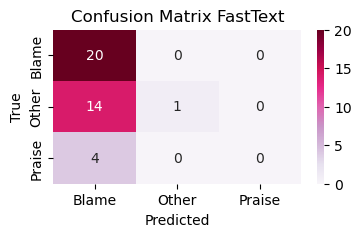

In [59]:
#confusion matrix
cm= confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=['Blame', 'Other', 'Praise'], yticklabels=['Blame', 'Other', 'Praise'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix FastText')
plt.show()